# COMP47670 Assignment 2: Text Classification
Code written by Aidan O'Sullivan

# Task 1: Data Collection

In [398]:
import urllib.request
import pandas as pd
import json
link = "http://mlg.ucd.ie/modules/COMP41680/assignment2/index.html"
response = urllib.request.urlopen(link)          # The information is retreived from the webiste corresponding to the link
html = response.read().decode()                  # Received information read and decoded

Relevant libraries are imported above, to faciliate the use of certain functions throughout the code. The website being scraped is http://mlg.ucd.ie/modules/COMP41680/assignment2/index.html and it containns an archive of Guardian news articles of 2020 seperated into their respectiuve months of release. Beautiful Soup is used to web scrape the the html structured articles and creates a parse tree that allows easy reference of different parts of the structure. 

In [399]:
import bs4
parser = bs4.BeautifulSoup(html,"html.parser")    # Parser tree is created

The first page that the link opens is a list of url links to each month of 2020 news stories. These can be found in the a tags of the parser tree. These a tags are appended to a list and the relevant bit of the url address is removed, which can be used later to scrape through all months of the website

In [879]:
months = parser('a')                              # The a tags in the parser tree of the first page are stored in months
month_a_tags = []                                 # List created to store a tag month structure for use in future url address
for month in months:                              # Loop through all a tags in this page
    news_months = month.get('href', 'none')       # Find the desired url information in the a_tag
    month_a_tags.append(news_months[:-8])         # The month structure of each url is removed
month_a_tags.pop(0)                               # Remove 1st row a tag as it contains irrelevant information
print(month_a_tags)

'in'

['month-jan-', 'month-feb-', 'month-mar-', 'month-apr-', 'month-may-', 'month-jun-', 'month-jul-', 'month-aug-', 'month-sep-', 'month-oct-', 'month-nov-', 'month-dec-']


Now that the url structure is extracted for each month web scraping can begin. For each month the program will enter the first page of the month purely to discern how many pages of news are available for each month. The number of pages can be found from the h4 tags, by removing the last two digits. The count is set to 1 to prevent the program performing the number of pages check again until all pages in the month have been looped through. 
The second for loop will loop through each page in the month until until the max page has been reached and then move onto the next month. The category of each article is checked to see if they are either Politics, Film, or Sport. If any of these are detected the category, title and snippet of the article will be appended to a list. These lists are added to a dictionary under there corresponding references. This dictionary is added to a .JSON file containing all the relevant information for every article in the chosen categories.

In [880]:
category_list = []                        # List for all cetgeories of relevant articles
titles = []                               # List for all titles of relevant articles
snippet = []                              # List for all snippets of relevant articles
dict_news = {}                            # Dictionary that will contain the above 3 lists for easy storage in JSON file
page_nums = ""                            # String declared that will contain the number of pages per month
for month_a_tag in month_a_tags:          # Loops through the list that contains all the url month information
    count = 0                             
    if count == 0:                                                                                  # If statement entered once per month at begining t see how many pages there are
        month_link = 'http://mlg.ucd.ie/modules/COMP41680/assignment2/' + month_a_tag +"001.html"   # URL of the first page of each month
        response = urllib.request.urlopen(month_link)                                               # Information retrieved from web page
        html_month = response.read().decode()                                                       # Web page read and decoded
        month_parser = bs4.BeautifulSoup(html_month,"html.parser")                                  # Parser tree of web page created for page #1 of each month                               
        h4_tag = month_parser.find("h4")                                                            # H4 tag contains information on max page number
        page_index = h4_tag.get_text()                                                              # Useful text it contains is obtained
        page_index = page_index[-2:]                                                                # Last two digits of the string are extracted as they contain max page number
        page_nums_int = int(page_index)                                                             # converted to int to be used to iterate through all pages
        count = 1                                                                                   # Ensures that this if statement will not be entered until the scraping of the next month's pages
    if count == 1:
        for page in range(1, (page_nums_int+1)):                                                    # Loops from 1 to the max page number
            page_str = str(page)                                                                    #zfill() and url requires a type string
            page_str = page_str.zfill(3)                                                            #Adding zeroes to the beginning to make it compatible 3 digit form as with URL structure
            month_link = 'http://mlg.ucd.ie/modules/COMP41680/assignment2/' + month_a_tag + page_str +".html"    # URL for each month and each page is constructed here
            response = urllib.request.urlopen(month_link)
            html_month = response.read().decode()
            month_parser = bs4.BeautifulSoup(html_month,"html.parser")
            for articles in month_parser.find_all("div",{"class":"article"}):                        # Loops through all articles in the page
                p_tags_title = articles.find_all('p')[1]                                             # P tags contains the category
                category = p_tags_title.get_text()                                                   # Useful text extracted containing the category
                if (category == 'Category: Sport' or category == 'Category: Politics' or category =='Category: Film'):   # Checks to see if category is of chosen type
                    category_list.append(category[10:])                                              # If category is of chosen type the category is appended to the list
                    h5_tag = articles.find("h5")                                                     #  H5 tag contains titles
                    a_tag = h5_tag.find("a")                                                         # The a tag is then extracted
                    titles.append(a_tag.get_text())                                                  # Useful text within a tags are appended to list
                    p_tags_snippet = articles.find_all('p')[2]                                       # The 3rd p tag of each article contains the snippet
                    snippets.append(p_tags_snippet.get_text())                                       # Snippet appended to list
#print(category_list)
#print(titles)
#print(snippets)
x = len(titles)
dict_news["categories"] = category_list                  # Category list added to dictionary
dict_news["titles"] = titles                             # Titles list added to dictionary
dict_news["snippets"] = snippets[-x:]                    # Snippets list added to dictionary
news_json = json.dumps(dict_news, indent=2)              # Structure converted to data string. Indent added to make it more readable
fout = open('news_info.json',"w")                        # File opened at location for json data to be stored
fout.write(news_json )                                   # JSON data written to file location
fout.close()                                             # File closed

1415944

The JSON file is opened and each reference form a column in a data frame for categories, snippets and titles

In [881]:
with open('news_info.json') as f:
  data = json.load(f)
category_df = pd.DataFrame.from_dict(data["categories"])
titles_df = pd.DataFrame.from_dict(data["titles"])
snippets_df = pd.DataFrame.from_dict(data["snippets"])
#print(snippets_df)

# Task 2: Binary Classification

All data frames are joined together and the head and tail are checked manually to ensure that each row comes from the same article. As the text from titles and snippets would be mined as a whole they were concatenated to one column

In [885]:
df_concat = titles_df + snippets_df                       # Titles and snippets concatenated    
news_df =  pd.concat([category_df, df_concat], axis=1)    # The category and concatenated dataframes are joined together in two seperate columns
news_df.columns = ["Categories", "News Text"]             # Columns are titles
print(news_df.tail(10))                                   # Tail checked to ensure they match
#print(df_concat.tail(5))

     Categories  \
5388   Politics   
5389   Politics   
5390   Politics   
5391       Film   
5392   Politics   
5393   Politics   
5394   Politics   
5395      Sport   
5396      Sport   
5397   Politics   

                                                                                                                                                                                                                                                News Text  
5388                  Passports and permits: what are the biggest changes to expect after Brexit?The bells of Big Ben will chime to mark the occasion but there will be no street parties or chaos on the roads for the arrival of Brexit at 11pm, when …  
5389      View from the EU: Britain 'taken over by gamblers, liars, clowns and their cheerleaders'Britain faces an uncertain future as it finally pulls clear of the EU’s orbit, continental commentators have predicted, its reputation for pragmatism …  
5390           Stanley Johnson con

Checks are carried out to ensure that there is no missing information from any article. The number of articles from each category were also checked to ensure that it was around the expected amount. The data checks were satisfactory

In [886]:
df_politics = news_df[news_df["Categories"] == "Politics"]
df_film = news_df[news_df["Categories"] == "Film"]
df_sport = news_df[news_df["Categories"] == "Sport"]
df_politics.isnull().sum()
df_film.isnull().sum()
df_sport.isnull().sum()
print(df_politics.count())
print(df_film.count())
print(df_sport.count())

Categories    0
News Text     0
dtype: int64

Categories    0
News Text     0
dtype: int64

Categories    0
News Text     0
dtype: int64

Categories    1808
News Text     1808
dtype: int64
Categories    1771
News Text     1771
dtype: int64
Categories    1819
News Text     1819
dtype: int64


Libraries from Scikit learn and natural language toolkit are imported to assist with data mining and machine learning classification tasks

In [888]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.stem import WordNetLemmatizer 

The function below will tokenise the text and split it up into strings of individual words. The strings are then lemmitised, producing different kind of words that exist in the combined snippet and title text. This involves the grouping together of different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. 

In [889]:
def lemma_tokenizer(text):
    standard_tokenizer = CountVectorizer().build_tokenizer()        # Use the standard scikit-learn tokenizer first
    tokens = standard_tokenizer(text)                               # All data is tokenised
    lemmatizer = WordNetLemmatizer()                                # Then use NLTK to perform lemmatisation on each token
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append(lemmatizer.lemmatize(token))            # Each token is lemmatised
    return lemma_tokens

This function mines the data further by converting the data to lower case so words can be grouped easier. Common stop words are removed that are unlikely to have much impact in indicating the class of the text. In the classification extra weight is given to words that occur frequency and words that occur less than 5 times are removed. Short words that are less than two digits long are removed. It was decided that some words that were two digits in length were important for classification e.g F1 for sport. 
A simple classfication is carrried out first, using a 3 nearest neighbor classifier. A cross validation score of 10 is used to estimate the accuracy by evaluating using 10 different subsets of the data for each train and test. 
The optimum parameters for classifying were then found using GridSearchCV. Every integer k value between 1 and 30 was tried as the number of nearest neighbour to decide what was optimum. The accuracy was graphed for each k value to allow for visual inspection.
Finally, a 3 nearest neighbor classifier was used to predict the model and it was graphed using a confusion matrix to inspect the distribution of positives and negatives for each classification.

In [904]:
def KNN_classifier(data, target, labels):                                   #Function inputs the data, target and labels for two classes
    global y
    map(str.lower, data)                                                    # All data is set to lowercase
    vectorizer = TfidfVectorizer(stop_words="english", tokenizer=lemma_tokenizer, min_df = 5)     # The vectoriser is created to mine the data
    X = vectorizer.fit_transform(data)                                      # The vectoriser is applied to the data
    terms = vectorizer.get_feature_names()                                   
    terms = [ word for word in terms if len(word) > 2 ]                     # Words shorter than 2 are removed
    #print(terms)
    #print(target)
    model = KNeighborsClassifier(n_neighbors=3)                            # 3 nearest neighbor model created
    acc =  cross_val_score(model, X, target, cv=10, scoring="accuracy")    # Model applied to the data with class validation score of 10
    print(acc)                                                             # Print all 10 accuracy score for each subset
    print("KNN: Mean cross-validation accuracy = %.2f" % acc.mean())       # Find the mean of the scores
    
    #Calculate using GridSearchCV
    k_range = range(1,31)                                                  # K from 0-30
    knn = KNeighborsClassifier()                                           # K nearest neighbor classifier model created
    param_grid = dict(n_neighbors=k_range)                                 # Tried with each value of k
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)   # Creates knn for each option to find the optimum model
    grid.fit(X, target)                                                    # Train model to the data using the target
    grid_mean_scores = grid.cv_results_['mean_test_score']                 # Finds to accuracy score for each model
    #print(grid_mean_scores)
    plt.plot(k_range, grid_mean_scores)                                    # Plots the accuracy for each value of k
    plt.xlabel('Value of K for KNN')                                       # Plots k on the x-axis
    plt.ylabel('Cross-Validated Accuracy')                                 # Plots accuracy in y-axis
    
    # calculate the confusion matrix
    data_train, data_test, target_train, target_test = train_test_split(X, target, test_size=0.25)  # No cross validation so the model is split into test and train
    model = KNeighborsClassifier(n_neighbors=3)                             # 3 nearest neighbor model used
    model.fit(data_train, target_train)                                     # Model fir to train data
    predicted = model.predict(data_test)                                    # Model tried on the test data
    acc = accuracy_score(target_test, predicted)                            # Compared with the target to obtain accuracy score
    print("KNN single accuracy for the confusion matrix = %.2f" % acc)      # Accuracy score printed
    cm = confusion_matrix(target_test, predicted)                           # Confusion matrix generated
    # display it graphically
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)                 # Corresponding labels added
    cmd.plot();                                                             # Plotted

# Sport and Politics
The cross validation score is a good means of estimating the accuracy as it uses many different different versions of the train and test data to give a repersentitive accuracy when it is averaged. 94 % accuracy (I am aware parameters and graphs will change when run again, current ones were used for the sake of analysis) is a satisfactory level of prediction as it will predict the class most times. This is due to extensive text mining and preprocessing of the text. GridSearchCV shows that the accuracy of the KNN will improve as k is increased before plateauing before k = 30. 
The confusion matrix shows the number of positive guesses and wrong guesses for both classes. A similiar number of wrong and right guesses are present for both classes.

C:\Users\bantr\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[0.9476584  0.9338843  0.93939394 0.92286501 0.96143251 0.9476584
 0.96969697 0.95027624 0.93093923 0.93922652]
KNN: Mean cross-validation accuracy = 0.94
KNN single accuracy for the confusion matrix = 0.94


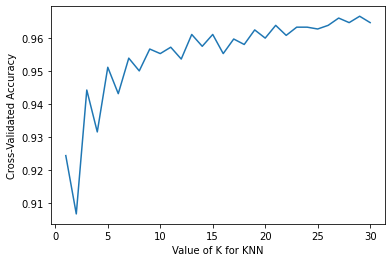

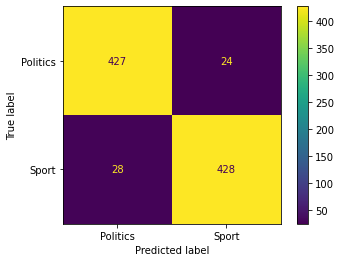

In [905]:
sport_target = df_sport["Categories"].astype(str).tolist()            # Sports category label targets are converted to lists as strings
sport_data = df_sport["News Text"].astype(str).tolist()               # Sports test data is converted to lists as strings
politics_target = df_politics["Categories"].astype(str).tolist()      # Politics category label targets are converted to lists as strings
politics_data = df_politics["News Text"].astype(str).tolist()         # Politics test data is converted to lists as strings
sport_politics_data = sport_data + politics_data                      # Data is joined as 1 list
sport_politics_target = sport_target + politics_target                # Target is joined as 1 list
#print(sport_politics_target)
labels = ["Politics", "Sport"]                                        # Labels for confusion matrix
KNN_classifier(sport_politics_data, sport_politics_target, labels)    # Data, targets and labels are passed to the classifier function

# Sport and Film
The average accuracy decreases for these datasets down to an average of 91%. This may be due to one of the data sets being harder to classify, maybe because it has less common keywords or words overlapping with another class that are quite dominant in the other data set. From checking the confusion matrix the model seems to perform worse on Film, with 19 less positives than for sport. Sport also has a considerable amount of false positives. I suspect the similarity between both datasets has reduced the accuracy, particularly as you might find many film that are about sport, which would confuse the predictions slightly, compared with sports and politics which rarely overlap. The GridSearchCV again shows an increase in accuracy as k increases, rising rapidly until 10 before falling to a very slow rise. 

C:\Users\bantr\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[0.89972145 0.90529248 0.88579387 0.90529248 0.92200557 0.93593315
 0.9275766  0.90250696 0.90529248 0.87465181]
KNN: Mean cross-validation accuracy = 0.91
KNN single accuracy for the confusion matrix = 0.91


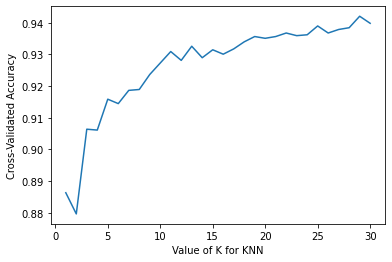

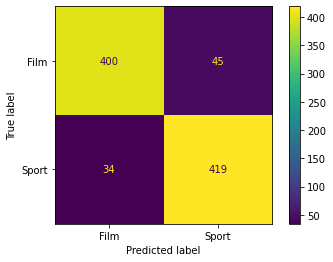

In [900]:
sport_target = df_sport["Categories"].astype(str).tolist()
sport_data = df_sport["News Text"].astype(str).tolist()
film_target = df_film["Categories"].astype(str).tolist()
film_data = df_film["News Text"].astype(str).tolist()
sport_film_data = sport_data + film_data
sport_film_target = sport_target + film_target
#print(sport_film_target)
labels = ["Film", "Sport"]
KNN_classifier(sport_film_data, sport_film_target, labels)  

# Film and Politics
The accuracy is improved again for this dataset compared with sport and film at 94%. Film and politics are observed from the confusion matrix to be predicted with close to the same accuracy. GridSearchCV improves the accuracy again with an increasing k, before plateauing before 30.

C:\Users\bantr\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[0.93854749 0.93296089 0.9301676  0.93575419 0.9301676  0.9301676
 0.94134078 0.95530726 0.94134078 0.92156863]
KNN: Mean cross-validation accuracy = 0.94
KNN single accuracy for the confusion matrix = 0.94


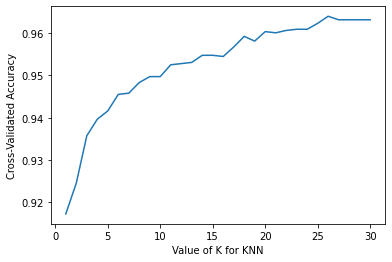

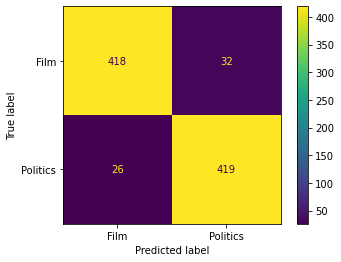

In [901]:
politics_target = df_politics["Categories"].astype(str).tolist()
sport_data = df_politics["News Text"].astype(str).tolist()
film_target = df_film["Categories"].astype(str).tolist()
film_data = df_film["News Text"].astype(str).tolist()
politics_film_data = politics_data + film_data
politics_film_target = politics_target + film_target
#print(sport_film_target)
labels = ["Film", "Politics"]
KNN_classifier(politics_film_data, politics_film_target, labels)

# Task 3-  Multi-Class Text Classification
Multiclass classification of all 3 news story categories was carried out using random forest. This method works by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes. The data was collected togehter as one target and dataset. in the cell below

In [872]:
sport_target = df_sport["Categories"].astype(str).tolist()
sport_data = df_sport["News Text"].astype(str).tolist()
film_target = df_film["Categories"].astype(str).tolist()
film_data = df_film["News Text"].astype(str).tolist()
politics_target = df_politics["Categories"].astype(str).tolist()
politics_data = df_politics["News Text"].astype(str).tolist()
multiclass_data = sport_data + film_data + politics_data
multiclass_target = sport_target + film_target + politics_target
#print(multiclass_target)

Similiar preprocessing steps are carried out as before to tokenise, lemmatize and remove infrequent and short words, while weighting frequent words. The train (80%) and test (20%) data is split. First a simple Random forest model is used to check the baseline accuracy, attempts will be made to improve it. An accuracy score of 93.8% was obtained which is already quite high for 40 estimator trees. 

In [906]:
from sklearn.ensemble import RandomForestClassifier                                       # Random Forest library is imported
map(str.lower, multiclass_data)                                                           # Text set to lowercase
vectorizer = TfidfVectorizer(stop_words="english", tokenizer=lemma_tokenizer, min_df = 5) # could use GridsearchCV to find the optimum model
X = vectorizer.fit_transform(multiclass_data)                           # Vectoriser applied to the data
terms = vectorizer.get_feature_names()                                 
terms = [ word for word in terms if len(word) > 2 ]                     # Words shorter than 2 are removed
#print(terms)
data_train, data_test, target_train, target_test = train_test_split(X, multiclass_target, test_size=0.2)    # Test and train data split
model = RandomForestClassifier(n_estimators=40)                         # Random forest model created using 40 estimator trees
model.fit(data_train,target_train)                                      # Trained using the train data
model.score(data_test, target_test)                                     # Accuracy score is found

C:\Users\bantr\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


RandomForestClassifier(n_estimators=40)

0.9481481481481482

For the predicted data set a confusion matrix is obtained. Politics is considerably the most succesfully predicted class and sport performs the worse. 

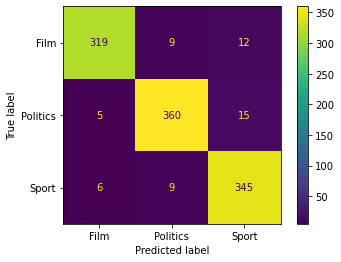

In [907]:
predicted = model.predict(data_test)
cm = confusion_matrix(target_test, predicted)
    # display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=["Film", "Politics", "Sport"])  
cmd.plot();
#cm = confusion_matrix(target_test, predicted, display_labels=["Film", "Politics", "Sport"])
#cm

GridSearchCV is agin used to obtain the optimum parameters. A range of each paramter is used and a tree will be built for each option. Cross validation is also applied in order to average the accuracy and give a true repersentation. The best parameters are acquired and will be subsequentially used to predict. The Bootstrap Aggregation algorithm for creating multiple different models from a single training dataset. The max_depth of a tree in Random Forest is defined as the longest path between the root node and the leaf node. Max features is the maximum number of features Random Forest is allowed to try in individual tree. N estimators is the number of trees that the model will build

In [831]:
param_grid = {                                # A range of different possible parameters will be explored by GridSearchCV
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rfc=RandomForestClassifier()
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv = 3, n_jobs = 4, verbose = 2) #add n_jobs = 4 to speed it up
CV_rfc.fit(data_train, target_train)
CV_rfc.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 864 out of 864 | elapsed:  7.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 1000}

The best parameters are found, interestingly 1000 estimator trees are recomended which is far higher than what I intially used. An accuracy of 95.2% is found, which is only around 1% improvement in accuracy, though this is quite significant in machine learning. A confusion matrix is created and again politics performs the best and sport the worse. The number of correct guesses for each class has improved slightly as well. 

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   54.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 864 out of 864 | elapsed:  5.1min finished


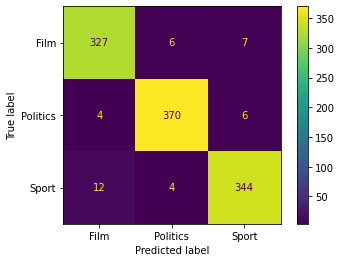

In [911]:
optimised_model = CV_rfc.fit(data_train, target_train)                           # Model train on train data
predicted=optimised_model.predict(data_test)                                     # Trained model used on test data
cm = confusion_matrix(target_test, predicted)                                    # Confusion matrix obtained
cmd = ConfusionMatrixDisplay(cm, display_labels=["Film", "Politics", "Sport"])   # Displayed graphically and labelled
cmd.plot();                                                                      # Plotted

In [910]:
optimised_model.score(data_test, target_test)  # Accuracy score found

0.9574074074074074